# Analyse the embeddings

### 1.1 import

In [3]:
import warnings

from matplotlib.pyplot import subplots

%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import json
from DBPR import utils
from DBPR import model
from DBPR import dataset
import torch
import pandas as pd

import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2. logger set up

In [4]:
utils.setuplogger(verbose = True, log_name="Embedding_explore")

In [5]:
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


### 1.3. Metric computing

In [5]:
dataset_name = 'postcovid'
algo_name = 'Bivaecf_cornac'

embs = []
for i_fold in range(5) :
    embs.append(pd.read_csv(f'../embs/{dataset_name}_{algo_name}_Iter_fold{i_fold}_seed_{0}.csv', header=None).to_numpy())

FileNotFoundError: [Errno 2] No such file or directory: '../embs/postcovid_Bivaecf_cornac_Iter_fold0_seed_0.csv'

In [6]:
dataset_name = 'portrait'
layer_n = 2
algo_name = f'DotProduct_{layer_n}_without_init_cont_model'

embs = []
for i_fold in range(5) :
    embs.append(pd.read_csv(f'../embs/{dataset_name}_{algo_name}_fold_{i_fold}_seed_{0}.csv', header=None).to_numpy())

FileNotFoundError: [Errno 2] No such file or directory: '../embs/portrait_DotProduct_2_without_init_cont_model_fold_0_seed_0.csv'

#### 1.3.3. DOA

In [ ]:
reload(utils)
utils.compute_doa(embs, dataset_name, algo_name)

#### 1.3.2. Correlation coeff

In [ ]:
reload(utils)
utils.compute_corr_coeff(embs=embs, dataset_name=dataset_name,fold_nb=5)

#### 1.3.1. RM

In [ ]:
reload(utils)
utils.compute_rm(embs=embs, dataset_name=dataset_name)

### 1.4. Qualitative study
#### 1.4.1. Imports

In [6]:
# choose dataset here
dataset_name = 'postcovid'
version= ""#"_small"
# modify config here

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

config = {

    # General params
    'seed' : 0,

    # Saving params
    'load_params': False,
    'save_params': False,
    'embs_path' : '../embs/'+str(dataset_name),
    'params_path' :'../ckpt/'+str(dataset_name),

    # training mode
    'early_stopping' : True,
    'fast_training' : True, # (Only taken in account if early_stopping == true) If true, doesn't compute valid rmse PC-ER

    # Learning params
    'learning_rate': 0.001,
    'batch_size': 2048,
    'num_epochs': 200,
    'num_dim': 10, # for IRT or MIRT todo : is it necessary as we use concepts knowledge number as embedding dimension ?
    'eval_freq' : 1,
    'patience' : 30,
    'device': device,
    'lambda' : 7.7e-6,
    'tensorboard': False,
    'flush_freq' : True,

    # for NeuralCD
    'prednet_len1': 128,
    'prednet_len2': 64,
    'best_params_path':'',

    #For GCCD
    'num_layers': 0,
    'version': 'pair',
    'p_dropout': 0,
    'low_mem_mode' : True,
    'user_nbrs_n' : 10,
    'item_nbrs_n' : 5
}
concept_map = json.load(open(f'../datasets/{dataset_name}/concept_map.json', 'r'))
concept_map = {int(k):[int(x) for x in v] for k,v in concept_map.items()}
metadata = json.load(open(f'../datasets/{dataset_name}/metadata.json', 'r'))
utils.set_seed(config['seed'])
dataset_name += version
logging.info(f'#### {dataset_name} ####')
logging.info(f'#### config : {config} ####')

CUDA is not available. Using CPU.
CUDA is not available. Skipping CUDA seed setting.
[INFO 10:48] #### postcovid ####
[INFO 10:48] #### config : {'seed': 0, 'load_params': False, 'save_params': False, 'embs_path': '../embs/postcovid', 'params_path': '../ckpt/postcovid', 'early_stopping': True, 'fast_training': True, 'learning_rate': 0.001, 'batch_size': 2048, 'num_epochs': 200, 'num_dim': 10, 'eval_freq': 1, 'patience': 30, 'device': device(type='cpu'), 'lambda': 7.7e-06, 'tensorboard': False, 'flush_freq': True, 'prednet_len1': 128, 'prednet_len2': 64, 'best_params_path': '', 'num_layers': 0, 'version': 'pair', 'p_dropout': 0, 'low_mem_mode': True, 'user_nbrs_n': 10, 'item_nbrs_n': 5} ####


In [ ]:
from statsmodels.stats.diagnostic import lilliefors
from scipy import stats

emb = pd.read_csv(f'../embs/{dataset_name}_DotProduct_{3}_cont_model_fold_{i_fold}_seed_{0}.csv', header=None).to_numpy()
for dim in range(metadata['num_dimension_id']):
            stat, p_value = stats.shapiro(emb[:, dim])
            print("Shapiro -- stat :",stat,"p_value :",p_value)

            stat, p_value = lilliefors(emb[:, dim], dist='norm')
            print("Lilliefors -- stat :",stat,"p_value :",p_value)
            print()

In [7]:
import re
import csv

def parse_log_to_csv(log_path, csv_path):
    """
    Parse the given log file and write metrics to a CSV.

    The CSV columns are:
    rmse,rmse_std,mae,mae_std,r2,r2_std,pc-er,pc-er_std,doa,doa_std,rm,rm_std,d_in,num_responses,exec_time

    A new CSV row is created each time a full set of metrics
    is detected (rmse/mae/r2/pc-er/doa/rm + d_in + num_responses; exec_time is optional).
    """

    # Regex patterns for lines with mean +- std and lines with single numeric value
    # Example lines to match:
    #   [INFO 09:27] rmse : 0.2900 +- 0.0006
    #   [INFO 09:27] d_in : 2
    #   [INFO 09:41] exec time :824.8757169246674
    pattern_mean_std = re.compile(r'^\[INFO.*?\]\s*(\S+)\s*:\s*([0-9.+-e]+)\s*\+\-\s*([0-9.+-e]+)')
    pattern_single_val = re.compile(r'^\[INFO.*?\]\s*(\S+)\s*:\s*([0-9.+-e]+)')

    # We'll accumulate each row's data in a dictionary
    # When we detect that the row is complete, we store it and reset
    metrics_list = []
    current_metrics = {}

    def reset_current_metrics():
        return {
            'rmse': None,
            'rmse_std': None,
            'mae': None,
            'mae_std': None,
            'r2': None,
            'r2_std': None,
            'pc-er': None,
            'pc-er_std': None,
            'doa': None,
            'doa_std': None,
            'rm': None,
            'rm_std': None,
            'd_in': None,
            'num_responses': None,
            'time': None,
        }

    # Initialize the dictionary for the first "block"
    current_metrics = reset_current_metrics()

    # Helper function: check if we have a "complete" set
    def has_all_required_metrics(m):
        """
        By default, we consider a row 'complete' if we have
        at least all of the fundamental metrics except maybe exec_time.
        """
        required = ['rmse','rmse_std','mae','mae_std','r2','r2_std','pc-er','pc-er_std',
                    'doa','doa_std','rm','rm_std','d_in','num_responses','time']
        return all(m[k] is not None for k in required)

    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Look for the pattern with mean +- std
            match_mean_std = pattern_mean_std.match(line)
            if match_mean_std:
                metric_name = match_mean_std.group(1).lower()   # e.g. "rmse", "mae", etc.
                mean_val = float(match_mean_std.group(2))
                std_val = float(match_mean_std.group(3))

                # Special case: "pc-er" or "pc-er_std" doesn't become "pc_er", so keep the dash
                if metric_name in current_metrics:
                    # e.g. current_metrics["rmse"] = X, current_metrics["rmse_std"] = Y
                    current_metrics[metric_name] = mean_val
                    current_metrics[f"{metric_name}_std"] = std_val

                continue  # Move on to next line

            # Look for single-value pattern
            match_single_val = pattern_single_val.match(line)
            if match_single_val:
                metric_name = match_single_val.group(1).lower()
                val = float(match_single_val.group(2))  # might be d_in, num_responses, or exec time

                # handle "exec time" or "exec_time"
                # The logs might appear as "exec time" or "exec_time"
                if 'exec' in metric_name and 'time' in metric_name:
                    current_metrics['exec_time'] = val
                elif metric_name in current_metrics:
                    # e.g. d_in, num_responses
                    current_metrics[metric_name] = val

            # If we see the separator "----------", that might be the end of a block
            # or if we see that we already have all metrics, we can store the row.
            if '----------' in line:
                # If the block is complete, push it
                if has_all_required_metrics(current_metrics):
                    metrics_list.append(current_metrics)
                # Start a fresh dictionary for the next block
                current_metrics = reset_current_metrics()

        # At the very end, if there's a final set of metrics that is complete, save it
        if has_all_required_metrics(current_metrics):
            metrics_list.append(current_metrics)

    # Write results to CSV
    fieldnames = [
        'rmse','rmse_std','mae','mae_std','r2','r2_std','pc-er','pc-er_std',
        'doa','doa_std','rm','rm_std','d_in','num_responses','time'
    ]

    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in metrics_list:
            # Convert None to empty string for CSV
            clean_row = {k: ("" if v is None else v) for k, v in row.items()}
            writer.writerow(clean_row)


import os
    # Example usage:
LOG_FILE = "~/Téléchargements/raw_data_postcovid.txt"   # Replace with the actual log path
CSV_FILE = "~/Téléchargements/data_postcovid.csv"  # Where you want to save the CSV

LOG_FILE = os.path.expanduser(LOG_FILE)
CSV_FILE = os.path.expanduser(CSV_FILE)
parse_log_to_csv(LOG_FILE, CSV_FILE)
print(f"Done! CSV written to {CSV_FILE}.")


Done! CSV written to /home/arthurb/Téléchargements/data_postcovid.csv.


In [ ]:
import re
import csv
import os

def parse_log_file(log_path, csv_path):
    """
    Parse a log file of the specified format and transform it into a CSV with columns:
    rmse,rmse_std,mae,mae_std,r2,r2_std,pc-er,pc-er_std,doa,doa_std,rm,rm_std,d_in,num_responses,exec_time
    """

    # This regex pattern captures lines such as:
    #   [INFO 09:41] rmse : 0.2900 +- 0.0007
    #   [INFO 09:41] exec time :824.8757
    #
    # Explanation:
    #   ^\[INFO\s+\d+:\d+\]\s+    --> the line begins with [INFO XX:XX]
    #   ([^:]+)\s*:\s*           --> capture everything up to the colon as group(1) (this can include spaces),
    #                               then match the colon and optional spaces
    #   ([\d\.]+)                --> capture the main metric (float) as group(2)
    #   (?:\s*\+\-\s*([\d\.]+))? --> optionally capture the std as group(3) if present
    #
    metric_regex = re.compile(
        r'^\[INFO\s+\d+:\d+\]\s+([^:]+)\s*:\s*([\d\.]+)(?:\s*\+\-\s*([\d\.]+))?'
    )

    # The columns we want in the final CSV
    columns = [
        "rmse", "rmse_std",
        "mae", "mae_std",
        "r2", "r2_std",
        "pc-er", "pc-er_std",
        "doa", "doa_std",
        "rm", "rm_std",
        "d_in",
        "time"
    ]

    # A mapping from the metric name in logs to the CSV column name.
    # Notice "exec time" here maps to "exec_time" in the CSV.
    # The keys here must match exactly what appears before the colon in the logs.
    metric_map = {
        'rmse': 'rmse',
        'mae': 'mae',
        'r2': 'r2',
        'pc-er': 'pc-er',
        'doa': 'doa',
        'rm': 'rm',
        'd_in': 'd_in',
        'time': 'time',
    }

    rows = []
    current_metrics = {}

    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            m = metric_regex.search(line)
            if m:
                metric_name = m.group(1).strip()  # e.g. 'rmse' or 'exec time'
                mean_val_str = m.group(2)         # e.g. '0.2900'
                std_val_str = m.group(3)          # e.g. '0.0007' (may be None)

                # If the metric name is recognized, store the values
                if metric_name in metric_map:
                    col_key = metric_map[metric_name]
                    # Convert to float
                    current_metrics[col_key] = float(mean_val_str)

                    # For metrics that can have a standard deviation, store it as well
                    if std_val_str is not None and metric_name in ['rmse', 'mae', 'r2', 'pc-er', 'doa', 'rm', 'time']:
                        current_metrics[col_key + '_std'] = float(std_val_str)

            # If line ends in '----------', we assume that block of metrics is finished
            if line.endswith('#### movielens ####'):
                if current_metrics:
                    rows.append(current_metrics)
                    current_metrics = {}

    # If the file does not end in '----------' but we still have a block partially filled, add it:
    if current_metrics:
        rows.append(current_metrics)

    # Write out the CSV
    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=columns)
        writer.writeheader()
        for row in rows:
            # Ensure all columns exist in the output; if missing, use an empty string
            out_row = {}
            for col in columns:
                out_row[col] = row.get(col, '')
            writer.writerow(out_row)

    print(f"Done! CSV written to: {csv_path}")

LOG_FILE = "~/Téléchargements/raw_data_postcovid.txt"   # Replace with the actual log path
CSV_FILE = "~/Téléchargements/data_movielens.csv"  # Where you want to save the CSV

LOG_FILE = os.path.expanduser(LOG_FILE)
CSV_FILE = os.path.expanduser(CSV_FILE)

parse_log_file(LOG_FILE, CSV_FILE)
print(f"Done! CSV written to {CSV_FILE}")


#### Methods comparisons

In [8]:
import pandas as pd

df = pd.read_csv("./data/portrait_hyperparam_study.csv", header=0, sep=",").astype(float)

In [9]:
df = df.rename(columns ={'rmse':'rmse_avg', 'mae':'mae_avg', 'pc-er':'pc-er_avg'})

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

import matplotlib.pyplot as plt

# Reset RC parameters to the default settings.
plt.rcdefaults()


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Reset RC parameters to the default settings.
plt.rcdefaults()

def plot_evolution_with_nb_params(metric, df):
    """
    Plots the evolution of a metric (with std dev),
    plus a secondary axis for the number of parameters.
    """
    # Sort dataframe for consistency
    df = df.sort_values('num_responses')

    ##########################################################
    # First axis (ax1) for your main metric
    ##########################################################

    fig, ax1 = plt.subplots()

    # Extract arrays for the main metric
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot mean +/- std
    line1 = ax1.plot(x, y, label=f"{metric} mean", color='tab:blue')
    ax1.fill_between(
        x, y - std, y + std,
        alpha=0.2, color='tab:blue',
        label=f"{metric} confidence interval ($\pm$ std)"
    )

    # Axis labels and style
    ax1.set_xlabel(r'$|M|$')
    ax1.set_ylabel(metric, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # X-axis ticks and limits
    ax1.set_xticks(x)
    ax1.set_xlim(left=4)

    # Y-axis limits to ensure they incorporate mean -/+ std
    y_min = df[metric + '_avg'].min() - df[metric + '_std'].max()
    y_max = (df[metric + '_avg'].max() + df[metric + '_std'].max()
             + 0.1 * (df[metric + '_avg'].max() - df[metric + '_avg'].min()))
    ax1.set_ylim(bottom=y_min, top=y_max)

    # Example vertical line from y_min to the avg at x=12
    selected_x = 12
    selected_y = df[df['num_responses'] == selected_x][metric + '_avg'].values[0]

    # Example horizontal line from x=4 to x=12 at that same selected_y
    ax1.hlines(
        y=selected_y,
        xmin=4,
        xmax=selected_x,
        color='black',
        linestyle='--',
        label='Selected hyperparameter'
    )

    # Make sure the main axes lines are visible
    ax1.set_facecolor('none')
    for spine in ['top', 'right', 'bottom', 'left']:
        ax1.spines[spine].set_visible(True)

    ##########################################################
    # Second axis (ax2) for the number of parameters
    ##########################################################

    ax2 = ax1.twinx()  # shares the same x-axis as ax1

    # Define a function to compute the number of parameters
    def nb_params(d_r:int, M:int):
        dim_n  = 9
        user_n = 1152
        quest_n = 116
        return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

    # Generate data for the second axis
    x2 = np.arange(5, 26)  # match the domain of x for consistency
    y2 = [nb_params(d_r=6, M=m) for m in x2]  # e.g., d_r=6

    line2 = ax2.plot(
        x2, y2,
        color='tab:green',
        label='Number of DBPR parameters'
    )

    # Label and style for second axis
    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Formatter to display large numbers as 'xx×10^3'
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e3)}$\\times10^3$"
    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))

    # Set y-limits for the second axis (adjust as needed)
    ax2.set_ylim(bottom=0, top=45000)

    # Example vertical line for the second axis at x=12, from 0 to y2
    x_v = selected_x
    y_v = nb_params(d_r=6, M=x_v)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    # from x=selected_x to the right
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        linestyle='--',
        color='black',
    )

    ##########################################################
    # Combine legends
    ##########################################################

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/" + str(metric) + "_portrait_hyperparam.pdf")
    plt.show()

# Example usage:
# plot_evolution_with_nb_params('exec_time', df[df['d_in']==6].drop_duplicates('num_responses'))


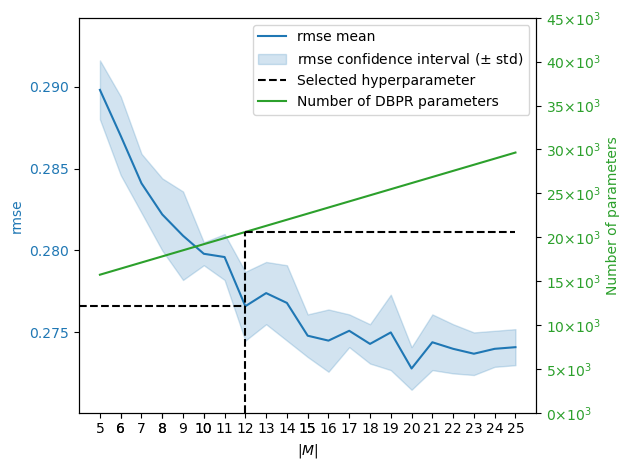

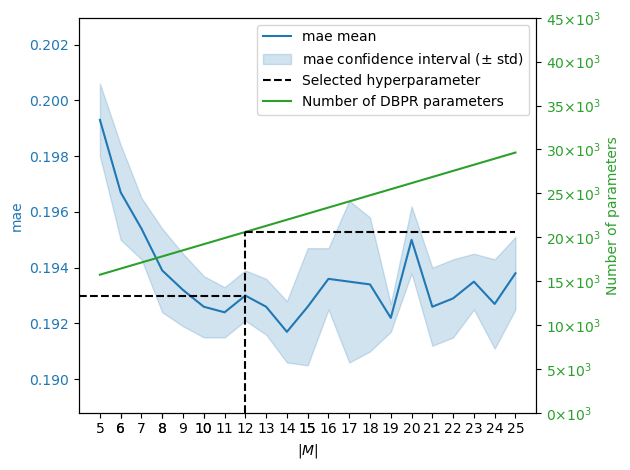

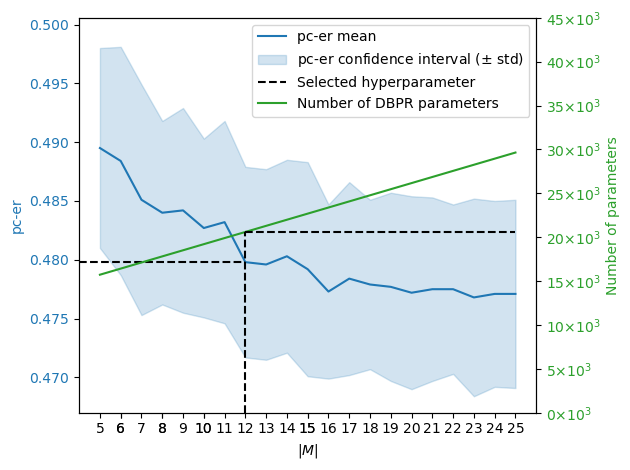

In [11]:
plot_evolution_with_nb_params('rmse',df[df['d_in']==6])
plot_evolution_with_nb_params('mae',df[df['d_in']==6])
plot_evolution_with_nb_params('pc-er',df[df['d_in']==6])

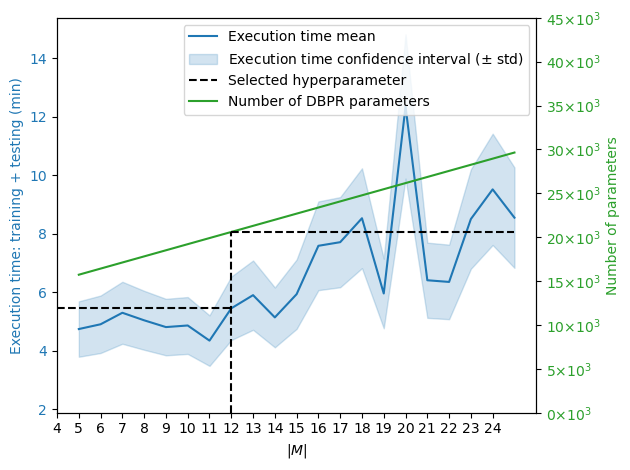

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_evolution_time_with_nb_params(metric, df):
    # Sort dataframe for consistency
    df = df.sort_values('num_responses')

    # Create figure and first axis (for execution times)
    fig, ax1 = plt.subplots()

    # Extract arrays for the first axis
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg'] / 60)   # Convert seconds to minutes
    std = np.array(df[metric + '_std'] / 60)   # Convert seconds to minutes

    # Plot mean +/- std for execution time
    line1 = ax1.plot(x, y, label='Execution time mean', color='tab:blue')
    ax1.fill_between(x, y - std, y + std, alpha=0.2, color='tab:blue',
                     label=f"Execution time confidence interval ($\pm$ std)")

    ax1.set_xlabel(r'$|M|$')
    ax1.set_ylabel("Execution time: training + testing (min)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # You can set the x-ticks and x-limits as you wish
    ax1.set_xticks(np.arange(4, 25))
    ax1.set_xlim(left=4)

    # Ensure the lower y-limit makes sense for your data
    y_min = (df[metric + '_avg'].min()/60 - df[metric + '_std'].max()/60)
    ax1.set_ylim(bottom=y_min)

    # Example vertical line (from y_min to the mean at x=12)


    # Example horizontal line (from x=4 to x=12 at the mean for x=12)
    ax1.hlines(
        y=df[df['num_responses'] == 12][metric + '_avg'].values[0] / 60,
        xmin=4,
        xmax=12,
        color='black',
        linestyle='--',
        label='Selected hyperparameter'

    )

    ###########################################################################
    # Create a second axis to plot the number of parameters
    ###########################################################################

    ax2 = ax1.twinx()  # shares the same x-axis with ax1

    def nb_params(d_r:int, M:int) :
        dim_n  = 9
        user_n = 1152
        quest_n= 116
        # Simple example formula (adjust if needed):
        return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

    # Generate data for the second plot
    # Make sure the range matches your x-axis from ax1
    x2 = np.arange(5, 26)
    y2 = [nb_params(d_r=6, M=m) for m in x2]  # Example: d_r=6

    line2 = ax2.plot(x2, y2, color='tab:green', label='Number of DBPR parameters')

    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # You can define a formatter to make large numbers more readable
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e3)}$\\times10^3$"

    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(bottom=0, top=45000)

    # Example vertical line for the second axis at x=12
    x_v = 12
    y_v = nb_params(d_r=6, M=x_v)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        color='black',
        linestyle='--',
    )

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/" + str(metric) + "_portrait_hyperparam.pdf")
    plt.show()

# Usage example (assuming you have loaded your DataFrame `df`):
plot_evolution_time_with_nb_params('exec_time', df[df['d_in']==6].drop_duplicates('num_responses'))


In [18]:
import pandas as pd

df = pd.read_csv("./data/movielens_hyperparam_study.csv", header=0, sep=",").astype(float)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def nb_params(d_r:int, M:int) :
        dim_n  = 11
        user_n = 4231
        quest_n= 2421
        # Simple example formula (adjust if needed):
        return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

Y = [nb_params(x,5) for x in range(2,22)]

def plot_evolution(metric,df) :

    df = df.sort_values('d_in')

    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot mean +/- std
    ax.plot(x, y, label=str(metric)+' mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label=str(metric)+" confidence interval ($\pm$ std)")


    ax.set_ylabel(metric, color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$d_r$')
    ax.set_xticks(np.arange(2,22))

    # If you want the x-axis to start at 0
    ax.set_xlim(left=1.5)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()-0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()), top = np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=10,
        ymin=df[metric + '_avg'].min()-0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()),       # start from y=0
        ymax=df[df['d_in']==10][metric + '_avg'],
        linestyle='--',
        color='black',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['d_in']==10][metric + '_avg'],
        xmin=0,
        xmax=10,
        color='black',
        label = 'Selected hyperparameter',
        linestyle='--',
    )

    ax.vlines(
        x=11,
        ymin=df[metric + '_avg'].min()-0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()),       # start from y=0
        ymax=np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max() - df[metric + '_avg'].min()),
        color='red',
        label = f'Users\' embedding dim $|C|$',
    )

    ax2 = ax.twinx()  # shares the same x-axis with ax

    # Generate data for the second plot
    # Make sure the range matches your x-axis from ax
    x2 = np.arange(2, 22)
    line2 = ax2.plot(x2, Y, color='tab:green', label='Number of DBPR parameters')

    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # You can define a formatter to make large numbers more readable
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e4)}$\\times10^4$"

    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(bottom=50000, top=450000)

    # Example vertical line for the second axis at x=12
    x_v = 10
    y_v = nb_params(d_r=x_v, M=5)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        color='black',
        linestyle='--',
    )

    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()

    plt.savefig("../../figs/"+str(metric) + "_movielens_hyperparam.pdf")

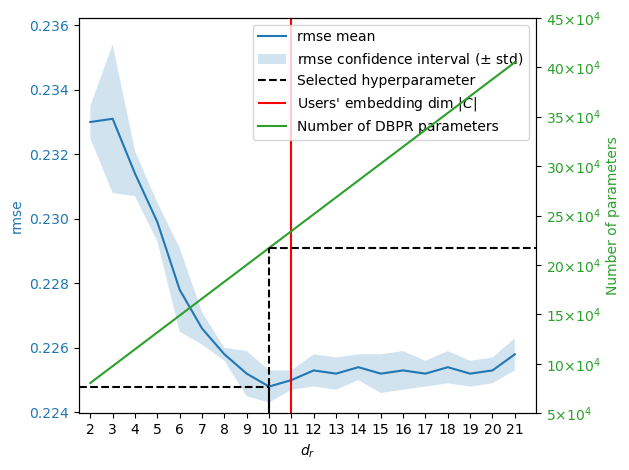

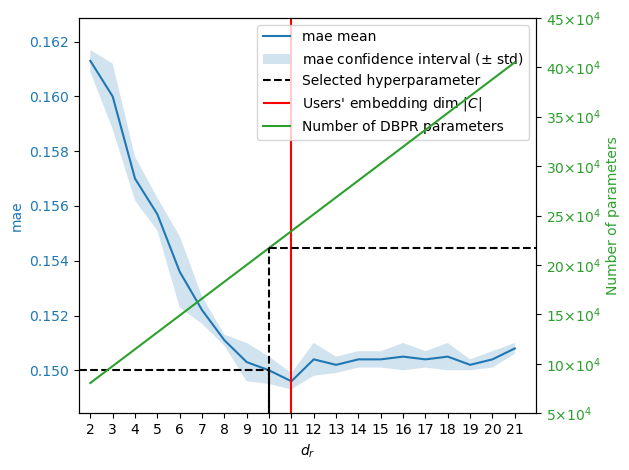

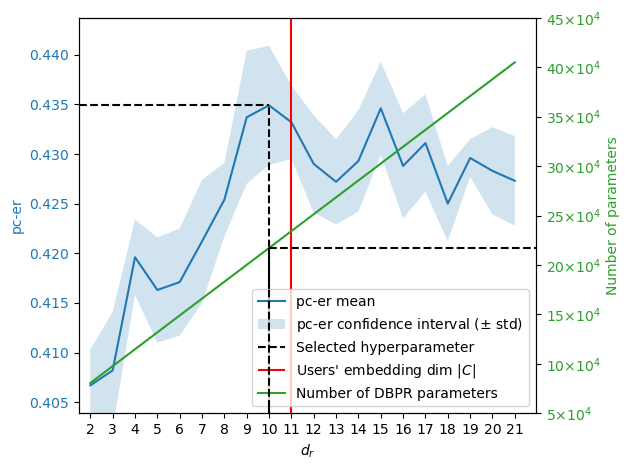

In [22]:
plot_evolution('rmse',df)
plot_evolution('mae',df)
plot_evolution('pc-er',df)

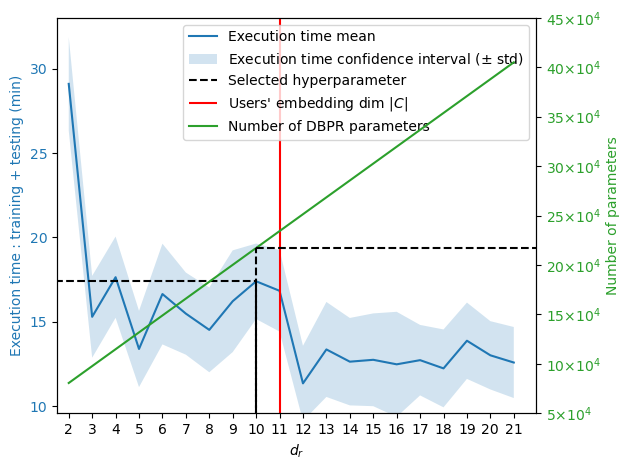

In [23]:
def plot_evolution_time(metric,df) :

    df = df.sort_values('d_in')
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg']/60)
    std = np.array(df[metric + '_std']/60)

    # Plot mean +/- std
    ax.plot(x, y, label='Execution time mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label="Execution time confidence interval ($\pm$ std)")


    ax.set_ylabel("Execution time : training + testing (min)", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$d_r$')
    ax.set_xticks(np.arange(2,22))

    # If you want the x-axis to start at 0
    ax.set_xlim(left=1.5)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=10,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=df[df['d_in']==10][metric + '_avg']/60,
        color='black',
        linestyle='--',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['d_in']==10][metric + '_avg']/60,
        xmin=0,
        xmax=10,
        color='black',
        linestyle='--',
        label = 'Selected hyperparameter'
    )

    ax.vlines(
        x=11,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),
        color='red',
        label = f'Users\' embedding dim $|C|$'
    )


    ax2 = ax.twinx()  # shares the same x-axis with ax

    # Generate data for the second plot
    # Make sure the range matches your x-axis from ax
    x2 = np.arange(2, 22)
    line2 = ax2.plot(x2, Y, color='tab:green', label='Number of DBPR parameters')

    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # You can define a formatter to make large numbers more readable
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e4)}$\\times10^4$"

    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(bottom=50000, top=450000)

    # Example vertical line for the second axis at x=12
    x_v = 10
    y_v = nb_params(d_r=x_v, M=5)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        color='black',
        linestyle='--',
    )

    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/"+str(metric) + "_movielens_hyperparam.pdf")

plot_evolution_time('exec_time',df)